In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Take a look at the data within 'measurement'
# set limit to 3 for readability
engine.execute('SELECT * FROM measurement limit 3').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0)]

In [6]:
# Take a look at the data within 'station'
# set limit to 3 for readability
engine.execute('SELECT * FROM station limit 3').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)]

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes/tables that automap found
# Confirmed this in DB Browser as well
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [12]:
# Determine possible date range

# Grab max date
max_date = engine.execute('select max(date) from measurement').fetchall()
print(max_date)

[('2017-08-23',)]


In [13]:
# Grab min date
min_date = engine.execute('select min(date) from measurement').fetchall()
print(min_date)

[('2010-01-01',)]


In [14]:
# Design a query to retrieve the last 12 months of precipitation data.

# Using max_date as a starting point, going back a year and using strptime
# https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
# %y vs %Y example 18 vs 2018
from datetime import datetime
prior_year = datetime.strptime('2016-08-23','%Y-%m-%d')

# Select only the `date` and `prcp` values.
# Grabbing a year's worth of data points
final_year_rain = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prior_year).all()


In [15]:
df = []
df = pd.DataFrame(final_year_rain, columns=['date','prcp'])
df = df.rename(columns = {'date':'Date'})
df.set_index('Date',inplace=True)
df['prcp'] = pd.to_numeric(df['prcp'])
df = df.rename(columns = {'prcp':'Precipitation'})
#df.count()
#print(df)

In [16]:
df=df.dropna(how='any')
#df.count()
#print(df)

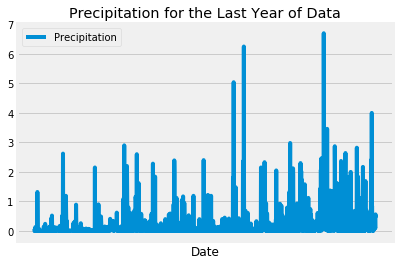

In [17]:
# Setting up the plot. Trying to get the date to print generally by month
# vs only a handful being displayed - haven't gotten it to work as desired
# https://matplotlib.org/gallery/ticks_and_spines/date_demo_rrule.html#sphx-glr-gallery-ticks-and-spines-date-demo-rrule-py
# https://matplotlib.org/api/dates_api.html

from matplotlib.dates import (MONTHLY, DateFormatter, rrulewrapper, RRuleLocator, drange)

rule = rrulewrapper(MONTHLY, bymonth=1, interval=1)
loc = RRuleLocator(rule)
formatter = DateFormatter('%Y/%m/%d')

ax = df.plot()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
#ax.xaxis.set_tick_params(roration=30,labelsize=10)
#ax.set_xticklabels(df.index,rotation=30)
ax.set_title("Precipitation for the Last Year of Data")
plt.autoscale(enable=True,axis='both',tight=None)
plt.show()

In [18]:
# Use Pandas to print the summary statistics for the precipitation data.
# My counts were different because I chose to drop the dates without data
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![precipitation](Images/precipitation.png)

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data

![describe](Images/describe.png)

In [63]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).group_by(Measurement.station).all()
#print(len(station_count))
print(f"There are {len(station_count)} stations in total.")

There are 9 stations in total.


In [64]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Station.station,Station.name, func.count(Measurement.station)).\
    filter(Station.station==Measurement.station).group_by(Station.station,Station.name).\
    order_by(func.count(Measurement.station).desc()).all()
station_activity

# Played around with it in dataframe format
#station_activity_df = pd.DataFrame(station_activity,columns=['Station ID','Location','Count'])
#station_activity_df

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [65]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


# Reference stuff for later
# https://stackoverflow.com/questions/8966538/syntax-behind-sortedkey-lambda
# https://docs.python.org/2/howto/sorting.html

# Find most active station using first row from previous step
station_activity[0][0]
most_active_station = (station_activity[0][0])

# calculate the lowest temperature recorded
low_temp = session.query(Measurement.tobs).\
    filter(Measurement.station==most_active_station).\
    order_by((Measurement.tobs).asc()).limit(1).all()
#low_temp  

# calculate the highest temperature recorded
high_temp = session.query(Measurement.tobs).\
    filter(Measurement.station==most_active_station).\
    order_by((Measurement.tobs).desc()).limit(1).all()
#high_temp  

# calculate the average temperature
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station==most_active_station).all()
#avg_temp

print(f"Station {(station_activity[0][0])} has the most activity.")
print(f"The lowest recorded temperature at station {(station_activity[0][0])} was {low_temp[0]}.")
print(f"The highest recorded temperature at station {(station_activity[0][0])} was {high_temp[0]}.")
print(f"The average temperature at station {(station_activity[0][0])} is {avg_temp[0]}.")

Station USC00519281 has the most activity.
The lowest recorded temperature at station USC00519281 was (54.0,).
The highest recorded temperature at station USC00519281 was (85.0,).
The average temperature at station USC00519281 is (71.66378066378067,).


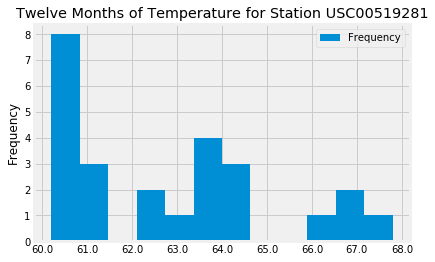

,Frequency
Temperature,
59.0,3
60.0,2
61.0,1
62.0,6
63.0,4
64.0,3
65.0,7
66.0,5
67.0,15


In [73]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Reusing 'most_active_station' (cell 45) to grab the station with most observations
# Reusing 'prior_year' (cell 14) since it was setup to for a year back

# Pull temps and temp counts for 1 year for station USC00519281
# If the file were to change and another station yielded a higher count, then the station would change

twelve_month_history = session.query(Measurement.tobs,func.count(Measurement.tobs)).\
    filter(Measurement.station==most_active_station).filter(Measurement.date >= prior_year).\
    group_by(Measurement.tobs).order_by((Measurement.tobs).asc()).all()
#twelve_month_history

# Setting up the data frame with index
twelve_month_history_df = pd.DataFrame(twelve_month_history,columns=['Temperature','Frequency'])
twelve_month_history_df.set_index('Temperature',inplace=True)

# Setting up the plot
ax = twelve_month_history_df.plot.hist(bins = 12)
ax.set_xticklabels(twelve_month_history_df.index)
ax.set_title(f"Twelve Months of Temperature for Station {most_active_station}")
plt.show()
twelve_month_history_df #.head(10)

In [67]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [68]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
